**Model Draft 16-01-25: GNN-LSTM Architecture**

**Model Overview**:
The goal is to classify each of the 360 parcels (nodes) in a subject's brain as "participating" or "not participating" (output: 1 or 0) in the task (0-back vs. 2-back) based on their time-series activation patterns and additional behavioral data (e.g., reaction time, accuracy).


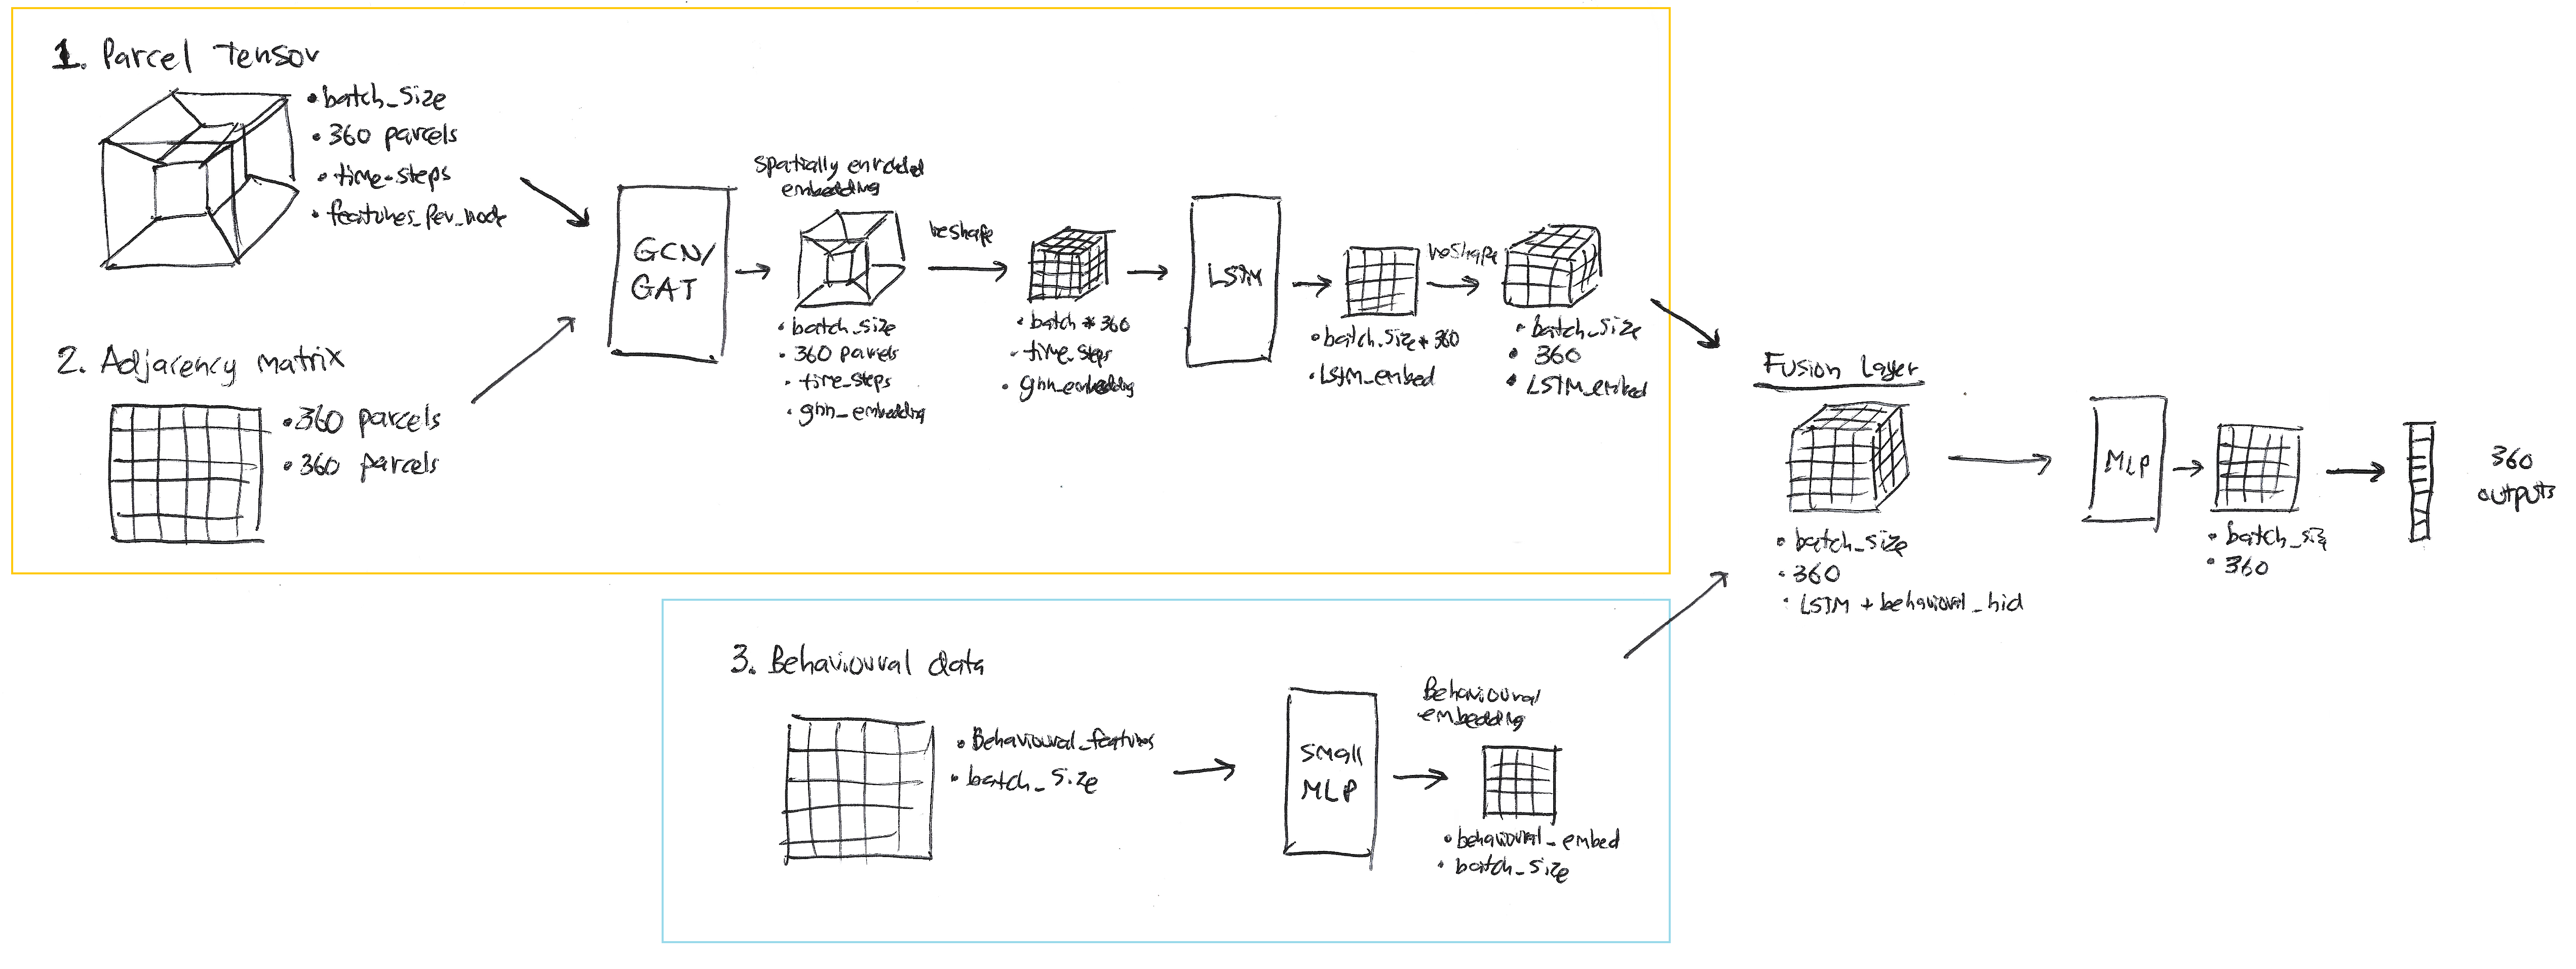

In [ ]:
#Data frames:

#Parcel tensor = 360 parcels, time_steps, features_per_node, batch_size
#Adjacency Matrix = 360 parcels, 360 parcels (correlations or thresholded binary values)
#Behavioural data Matrix = behavioural_features, batch size

In [ ]:
#Hyperparameters
num_parcels=360          # Number of parcels (nodes in the brain graph)
time_steps=50            # Number of time points in the fMRI time-series (arbitrary)
features_per_node=1      # node features (e.g., activation values, AUC_aa, AUC_ba, latencies)

gnn_hidden_dim=64        # Number of hidden units in the GNN layer
lstm_hidden_dim=128      # Number of hidden units in the LSTM

behavioral_features=2    # Number of behavioral features (e.g., RT, ACC)
behavioral_embedding_dim=32  # Behavioral data embedding size
mlp_hidden_dim=64        # Hidden layer size in the MLP

dropout_rate=0.5         # Dropout rate for regularization
batch_size = 32
learning_rate = 0.001
num_epochs = 20

In [ ]:
import torch
import torch.nn as nn
from torch_geometric.nn import GCNConv  # For GNN layers (PyTorch Geometric)

# Define the full model
class GNN_LSTM_MLP(nn.Module):
    def __init__(self, num_parcels, time_steps, features_per_node,
                 gnn_hidden_dim, lstm_hidden_dim,
                 behavioral_features, behavioral_embedding_dim,
                 mlp_hidden_dim, dropout_rate):
        super(GNN_LSTM_MLP, self).__init__()

        # Step 1: GNN Layer (Graph Convolution)
        self.gnn = GCNConv(features_per_node, gnn_hidden_dim)

        # Step 2: LSTM Layer for temporal relationships
        self.lstm = nn.LSTM(input_size=gnn_hidden_dim,
                            hidden_size=lstm_hidden_dim,
                            batch_first=True)

        # Step 3: Behavioral Data Processing (MLP for embedding)
        self.behavioral_mlp = nn.Sequential(
            nn.Linear(behavioral_features, behavioral_embedding_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate)
        )

        # Step 4: Fusion Layer + MLP for classification
        self.mlp = nn.Sequential(
            nn.Linear(lstm_hidden_dim + behavioral_embedding_dim, mlp_hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(mlp_hidden_dim, 1),  # Binary classification for each parcel
            nn.Sigmoid()  # Output probabilities
        )

    # Modularized propagation steps
    def forward(self, parcel_data, adj_matrix, behavioral_data):
        """
        Forward pass of the model.
        Processes the parcel data, adjacency matrix, and behavioral data.
        """
        # Step 1: GNN processing
        gnn_output = self.process_spatial(parcel_data, adj_matrix)

        # Step 2: LSTM processing
        lstm_output = self.process_temporal(gnn_output)

        # Step 3: Behavioral data processing
        behavioral_embedding = self.process_behavioral(behavioral_data)

        # Step 4: Fusion and classification
        combined_features = self.fuse_features(lstm_output, behavioral_embedding)
        output = self.classify(combined_features)

        return output  # Shape: (batch_size, num_parcels)

    # Step 1: Spatial processing (GNN)
    def process_spatial(self, parcel_data, adj_matrix):
        """
        Processes spatial relationships with GNN layers.
        Input shape: (batch_size, num_parcels, time_steps, features_per_node)
        Output shape: (batch_size, num_parcels, time_steps, gnn_hidden_dim)
        """
        batch_size, num_parcels, time_steps, _ = parcel_data.shape
        gnn_input = parcel_data.permute(0, 2, 1, 3).reshape(batch_size * time_steps, num_parcels, -1)
        gnn_output = self.gnn(gnn_input, adj_matrix)
        gnn_output = gnn_output.view(batch_size, time_steps, num_parcels, -1).permute(0, 2, 1, 3)
        return gnn_output

    # Step 2: Temporal processing (LSTM)
    def process_temporal(self, gnn_output):
        """
        Processes temporal relationships with LSTM layers.
        Input shape: (batch_size, num_parcels, time_steps, gnn_hidden_dim)
        Output shape: (batch_size, num_parcels, lstm_hidden_dim)
        """
        batch_size, num_parcels, time_steps, gnn_hidden_dim = gnn_output.shape
        lstm_input = gnn_output.reshape(batch_size * num_parcels, time_steps, gnn_hidden_dim)
        lstm_output, _ = self.lstm(lstm_input)
        lstm_output = lstm_output[:, -1, :]  # Take last time step
        lstm_output = lstm_output.view(batch_size, num_parcels, -1)
        return lstm_output

    # Step 3: Behavioral data processing
    def process_behavioral(self, behavioral_data):
        """
        Embeds behavioral data using a small MLP.
        Input shape: (batch_size, behavioral_features)
        Output shape: (batch_size, behavioral_embedding_dim)
        """
        behavioral_embedding = self.behavioral_mlp(behavioral_data)
        return behavioral_embedding

    # Step 4: Fusion of features
    def fuse_features(self, lstm_output, behavioral_embedding):
        """
        Combines LSTM output with behavioral embedding.
        Input shapes:
          - lstm_output: (batch_size, num_parcels, lstm_hidden_dim)
          - behavioral_embedding: (batch_size, behavioral_embedding_dim)
        Output shape: (batch_size, num_parcels, lstm_hidden_dim + behavioral_embedding_dim)
        """
        behavioral_embedding = behavioral_embedding.unsqueeze(1).repeat(1, lstm_output.size(1), 1)
        combined_features = torch.cat([lstm_output, behavioral_embedding], dim=-1)
        return combined_features

    # Step 5: Classification
    def classify(self, combined_features):
        """
        Classifies each parcel using an MLP.
        Input shape: (batch_size, num_parcels, lstm_hidden_dim + behavioral_embedding_dim)
        Output shape: (batch_size, num_parcels)
        """
        output = self.mlp(combined_features)
        return output.squeeze(-1)  # Remove last dimension

# Example usage
batch_size = 32
parcel_data = torch.rand(batch_size, num_parcels, time_steps, features_per_node)
behavioral_data = torch.rand(batch_size, behavioral_features)
adj_matrix = torch.eye(num_parcels)  # Example adjacency matrix (identity for simplicity)

# Initialize the model
model = GNN_LSTM_MLP(
    num_parcels=num_parcels,
    time_steps=time_steps,
    features_per_node=features_per_node,
    gnn_hidden_dim=gnn_hidden_dim,
    lstm_hidden_dim=lstm_hidden_dim,
    behavioral_features=behavioral_features,
    behavioral_embedding_dim=behavioral_embedding_dim,
    mlp_hidden_dim=mlp_hidden_dim,
    dropout_rate=dropout_rate
)

# Forward pass
output = model(parcel_data, adj_matrix, behavioral_data)
print("Output shape:", output.shape)  # Should be (batch_size, num_parcels)

In [ ]:
# Mock data generation
def generate_mock_data(batch_size, num_parcels, time_steps, features_per_node, behavioral_features):
    """
    Generate mock data for parcels, adjacency matrix, and behavioral features.
    """
    parcel_data = torch.rand(batch_size, num_parcels, time_steps, features_per_node)  # Random parcel data
    behavioral_data = torch.rand(batch_size, behavioral_features)  # Random behavioral data
    adj_matrix = torch.eye(num_parcels)  # Identity adjacency matrix (fully connected graph)
    labels = torch.randint(0, 2, (batch_size, num_parcels)).float()  # Binary labels for parcels
    return parcel_data, behavioral_data, adj_matrix, labels

In [ ]:
# Define optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.BCELoss()  # Binary Cross-Entropy Loss for parcel-wise binary classification

# Training loop
for epoch in range(num_epochs):
    # Set the model to training mode
    model.train()

    # Generate mock data for each epoch
    parcel_data, behavioral_data, adj_matrix, labels = generate_mock_data(
        batch_size, num_parcels, time_steps, features_per_node, behavioral_features
    )

    # Forward pass
    output = model(parcel_data, adj_matrix, behavioral_data)

    # Compute loss
    loss = loss_fn(output, labels)

    # Backpropagation and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print loss for the epoch
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item():.4f}")

# Evaluation loop
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    # Generate evaluation data
    parcel_data, behavioral_data, adj_matrix, labels = generate_mock_data(
        batch_size, num_parcels, time_steps, features_per_node, behavioral_features
    )

    # Forward pass
    output = model(parcel_data, adj_matrix, behavioral_data)

    # Example metrics
    predictions = (output > 0.5).float()  # Binary threshold at 0.5
    accuracy = (predictions == labels).float().mean()  # Compute accuracy
    print(f"Evaluation Accuracy: {accuracy.item():.4f}")
